### Sentiment Analysis of "Wall Street Bets" Daily Thread Comments
#### Is there a correlation of sentiment with GME price during the January frenzy?
Let's use Python's NLTK on Reddit API data (using the PRAW library) to check the sentiment of the comments to get a feel for the WSB subreddit as Game Stock stock (GME) flies to the moon and then craters back.<br><br>
The Vader Lexicon is a great resource for social media analysis, but may or may not serve well with the language used in WSB comments.<br>Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

#nltk.download('vader_lexicon') needed if you haven't downloaded lexicon before

In [2]:
# Get comment data from reddit
# I've already pickled the comments from the daily threads, see "reddit_wsb_data_pull.py" for specifics
# Data is ~January 2020
df = pd.read_pickle('wsb_daily_comments_Jan20.pkl')    #27000 comments

# remove deleted comments from analysis
df = df[df['tl_comment']!='[deleted]'] # 26000 comments
# includes: comment, score, comment posted time, parent id, parent posted time

In [3]:
# look at: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
# BUT this website did not cite the vader sentiment analysis tool as asked:
#
# Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
#
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

In [4]:
# Analyze sentiment for each comment
sentiment_results = df['tl_comment'].apply(sia.polarity_scores)
sentiment_results = pd.DataFrame([i for i in sentiment_results.values], index=sentiment_results.index)
sentiment_results = pd.concat([df,sentiment_results], axis=1)
# Note that I think this works more efficient and parallel than the way implemented on the above website
# add sentiment on the right side of sub dataframe

#### Note that vader does not seem to work well for some WSB comments. E.g.s:
"AMC held the line!!! (rockets)" is shown as neutral, but looks positive to me.<br>
"Hell yeah BB" half negative, but should be a positive sentiment.<br>
"Alexa Play Free Falling" is mostly considered positive but is referencing a falling stock/market and should be negative.
#### Is there an effect of lengths of comments and sentiment?
The scatter plot below shows that the longest comments tend to be entirely positive (+1) or negaive (-1) sentiment, I will presume this is because there are more words to be interpreted.

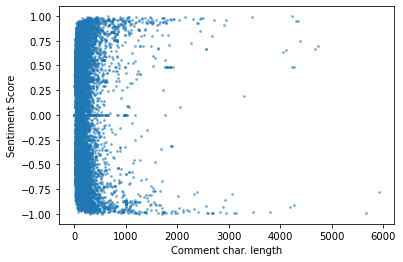

In [5]:
sentiment_results['com_length'] = sentiment_results['tl_comment'].apply(len)
plt.scatter(sentiment_results.com_length, sentiment_results.compound, s=3, alpha=0.5)
plt.xlabel('Comment char. length')
_=plt.ylabel('Sentiment Score')
# Longest comments are likely to show up at extremes of the scores, due to more words(?)

In [6]:
# use yfinance to query stock data, but to save snapshot I've pickled a month of GME data for jan 2021
hist = pd.read_pickle('GME_Data_Jan21.pkl')

#### Normalizing Sentiment
So we've estimated sentiment for each comment, but in order to get a daily value for the subreddit we need to average on the day. I think the best way to do this is to normalize this by the comment score so that more upvoted comments represent the sentiment more.<br><br>
Let's take a quick look at average vs. normalized average:

In [7]:
# If we look at sentiment over time in the daily threads, let's normalize it by comment score
# There is no option to weight in a daily mean, so we hack it together
sentiment_results['numerator'] =  sentiment_results['compound']*sentiment_results['tl_com_score']

normalized = sentiment_results.resample('D',on='parent_dt')['numerator'].sum() / sentiment_results.resample('D',on='parent_dt')['tl_com_score'].sum()
regular_avg = sentiment_results.resample('D',on='parent_dt')['compound'].mean()

normalized = pd.DataFrame(normalized, columns=["Normalized"]).join(hist, how='left')

# judgment call, i think that interpolating the missing days (weekends) is a good middle ground
normalized.interpolate(method='linear',inplace=True)
regular_avg.interpolate(method='linear',inplace=True)

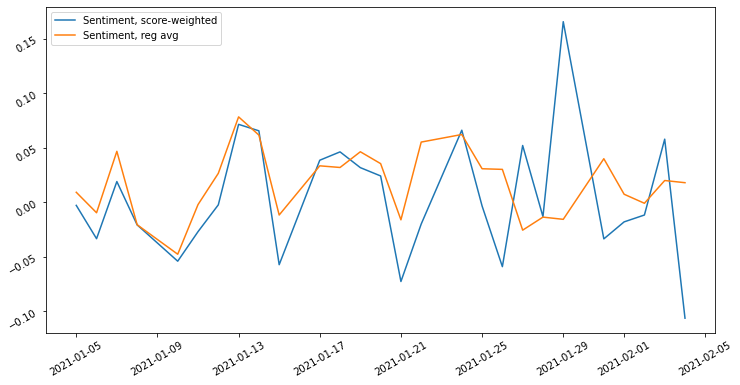

In [8]:
plt.figure(figsize=(12,6))
plt.plot(normalized.index, normalized.Normalized,label='Sentiment, score-weighted')
plt.plot(regular_avg.index, regular_avg,label='Sentiment, reg avg')
plt.tick_params(rotation=30)
_=plt.legend()

The plot above shows that normalizing by score shows some higher peaks around 1/29. This could just be due to some noise and single highly rated comments on thsoe days, but let's look on...
#### Sentiment vs. GME stock price
Let's plot the sentiment score and the high/low stock prices for each day. The sentiment peaks the day after a day of high volatility.

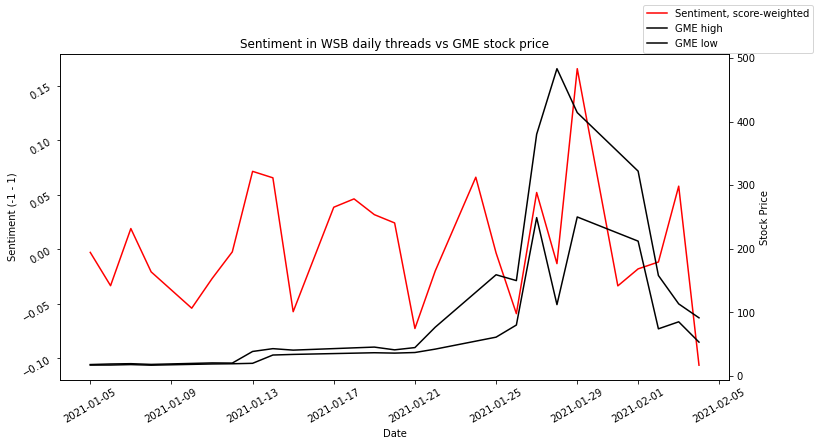

In [9]:
# What does the score-weighted peak look like compared to the GME stock price?
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(normalized.index, normalized.Normalized, label='Sentiment, score-weighted',c='r')
ax2.plot(normalized.index, normalized.High, label='GME high',c='k')
ax2.plot(normalized.index, normalized.Low, label='GME low',c='k')
fig.legend()
ax1.set_ylabel('Sentiment (-1 - 1)')
ax2.set_ylabel('Stock Price')
ax1.set_xlabel('Date')
ax1.set_title("Sentiment in WSB daily threads vs GME stock price")
ax1.tick_params(rotation=30)

But we can try testing the correlation (in scipy.stats, but easy to just use built-in function in pandas):

In [10]:
print("Pearson correlation: {:2f}".format(normalized.Normalized.corr(normalized.High,method='pearson')))
print("Kendall correlation: {:2f}".format(normalized.Normalized.corr(normalized.High,method='kendall')))
print("Spearman correlation: {:2f}".format(normalized.Normalized.corr(normalized.High,method='spearman')))

Pearson correlation: 0.302159
Kendall correlation: 0.156989
Spearman correlation: 0.235484


Well, the correlations are small, but I'd say that since all are positive and similar, we can say that there is probably a correlation between the GME stock price and the sentiment in the comments, but the sentiment tends to average close to 0. However, it also seems that sentiment analysis on the language used in WSB is difficult given the available lexicon.